# The Strategy

Our subimission has to give predictions for each of the locations separately. Hence in this notebook the main focus will be to create three separate models to produce three different predictions.

Things of **NOTE**:
- The observed and estimated datasets of location B and C have considerable window in between
- This does not apply to location A

In [213]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import xgboost as xgb
import math
import csv
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

In [214]:
train_a = pd.read_parquet('../A/train_targets.parquet')
train_b = pd.read_parquet('../B/train_targets.parquet')
train_c = pd.read_parquet('../C/train_targets.parquet')

X_train_estimated_a = pd.read_parquet('../A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('../B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('../C/X_train_estimated.parquet')

X_train_observed_a = pd.read_parquet('../A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('../B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('../C/X_train_observed.parquet')

X_test_estimated_a = pd.read_parquet('../A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('../B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('../C/X_test_estimated.parquet')

## Addresing the gap between observed and estimated weather data for location B and C

In [215]:
start, end = X_train_observed_b['date_forecast'].max(), X_train_estimated_b['date_forecast'].min()

gap = end - start
print("End of observed:", start, "\nBegining of estimated:", end, "\nGap:", gap)

End of observed: 2022-05-03 00:00:00 
Begining of estimated: 2022-10-28 22:00:00 
Gap: 178 days 22:00:00


In [216]:
start, end = X_train_observed_c['date_forecast'].max(), X_train_estimated_c['date_forecast'].min()

gap = end - start
print("End of observed:", start, "\nBegining of estimated:", end, "\nGap:", gap)

End of observed: 2022-05-01 22:00:00 
Begining of estimated: 2022-10-28 22:00:00 
Gap: 180 days 00:00:00


Considering **B**

<Axes: xlabel='date_forecast'>

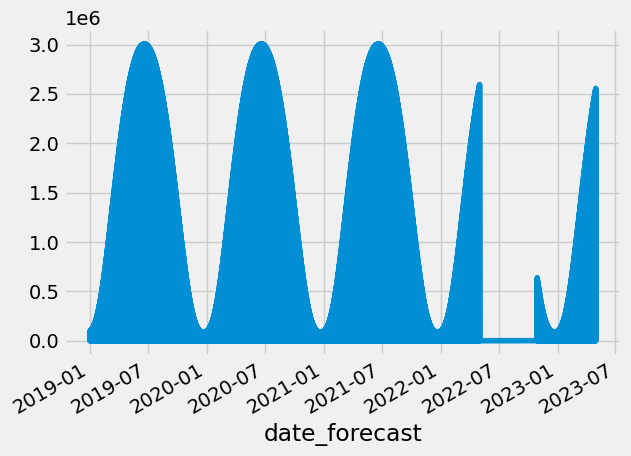

In [217]:
X_B = pd.concat([X_train_observed_b, X_train_estimated_b])
X_B.set_index('date_forecast', inplace=True)
X_B['clear_sky_energy_1h:J'].plot()


Filling in the gap dates with NaN values

<Axes: >

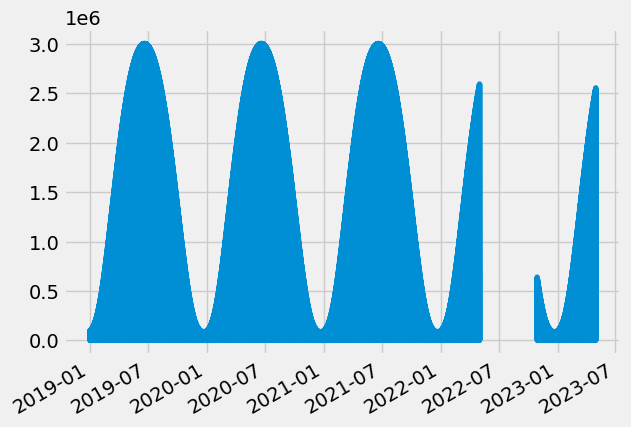

In [240]:
full_date_range = pd.date_range(start=X_B.index.min(), end=X_B.index.max(), freq='D')
missing_dates = full_date_range.difference(X_B.index)
missing_df = pd.DataFrame(index=missing_dates)
X_B_filled = pd.concat([X_B, missing_df]).sort_index()
X_B_filled['clear_sky_energy_1h:J'].plot()

<Axes: xlabel='time'>

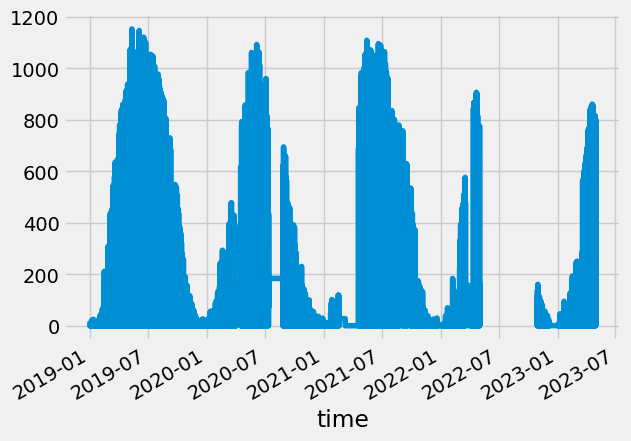

In [219]:
train_b.set_index('time', inplace=True)
train_b['pv_measurement'].plot()

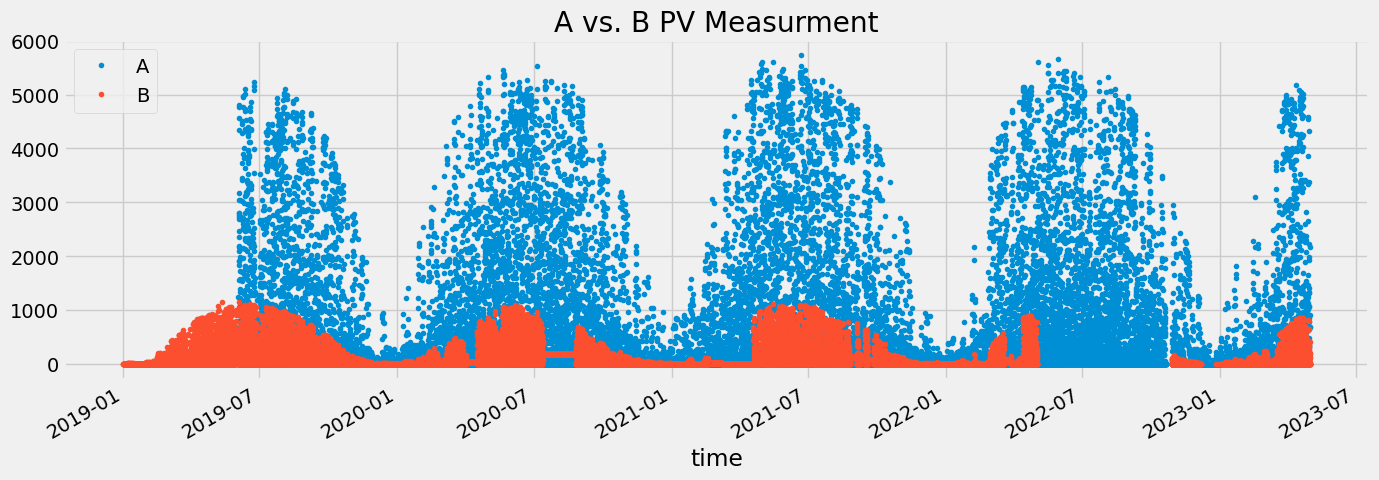

In [220]:
plt.figure(figsize=(15, 5))

if not isinstance(train_a.index, pd.DatetimeIndex):
    train_a.set_index('time', inplace=True)
    
train_a["pv_measurement"].plot(style='.', title='A vs. B PV Measurment')

train_b['pv_measurement'].plot(style='.')

plt.legend(['A', 'B'], loc='upper left')

# Display the plot
plt.show()

In [221]:
train_b = pd.read_parquet('../B/train_targets.parquet')

def find_repeated_rows(df):
    '''
    Returns all indicies (from, to) which have the largest intervals of being constant. The output is sorted from 
    largest to smallest.
    '''
    df = df.reset_index()
    repeated_temp = []
    intervals = []

    first = True

    for index, row in df.iterrows():
        if index == 0:
            continue
        if row['pv_measurement'] == df.iloc[index - 1]['pv_measurement']:
            repeated_temp.append(index)
            if first: 
                repeated_temp.insert(0, index - 1)
                first = False
        else:
            if len(repeated_temp) > 1:
                intervals.append((repeated_temp[0], repeated_temp[-1]))
            repeated_temp = []
            first = True

    return sorted(intervals, key=lambda t: t[1] - t[0], reverse=True)

intervals = find_repeated_rows(train_b)
print("The largest interval is", intervals[0])

The largest interval is (13409, 14466)


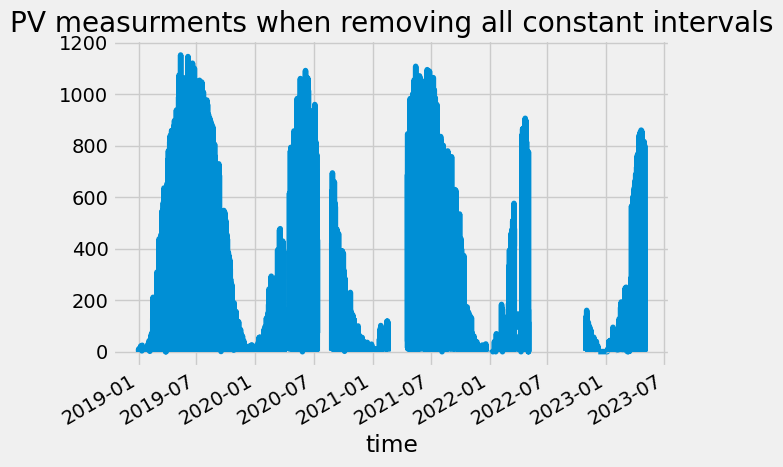

In [222]:
for start, end in intervals:
    for row_index in range(start, end + 1):
        train_b.at[row_index, 'pv_measurement'] = np.nan

train_b.set_index('time', inplace=True)
train_b['pv_measurement'].plot(title="PV measurments when removing all constant intervals")
plt.show()


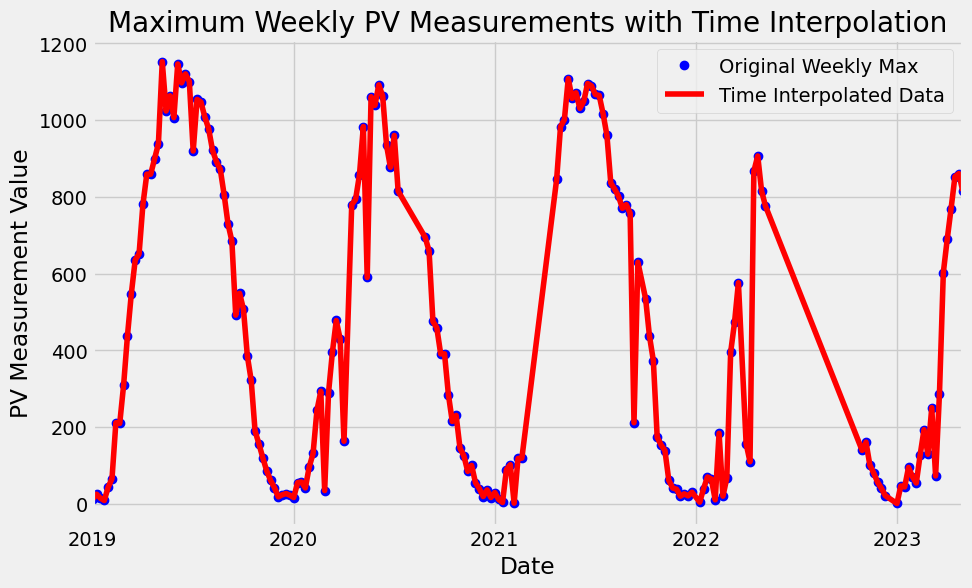

In [234]:
# 1. Resample data for weekly max
weekly_max = train_b['pv_measurement'].resample('W').max()

# 2. Drop NaN values for fitting
weekly_max_nonan = weekly_max.dropna()

weekly_max_interpolated = weekly_max.interpolate(method='time')

plt.figure(figsize=(10, 6))

# Original data
weekly_max.plot(marker='o', linestyle='', label="Original Weekly Max", color='blue')

weekly_max_interpolated.plot(marker='', linestyle='-', color='red', label="Time Interpolated Data")

plt.title("Maximum Weekly PV Measurements with Time Interpolation")
plt.ylabel("PV Measurement Value")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.show()


